In [1]:
import json
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import wikipedia
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from pandas.plotting import register_matplotlib_converters
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE

In [9]:
vids = pd.read_csv('files/df_sans_zero_sentiments.csv')
#filter out outliers with not many comments (not enough comments for sentiment analysis to be robust)
vids = vids[vids['commentCount'] > 100]

In [10]:
#6 equally distributed categories of likes/dislikes ratio
bin_labels = [0, 1, 2, 3, 4, 5]
vids['ratio_bins'] = pd.qcut(vids['ratio'], q=6, labels = bin_labels)

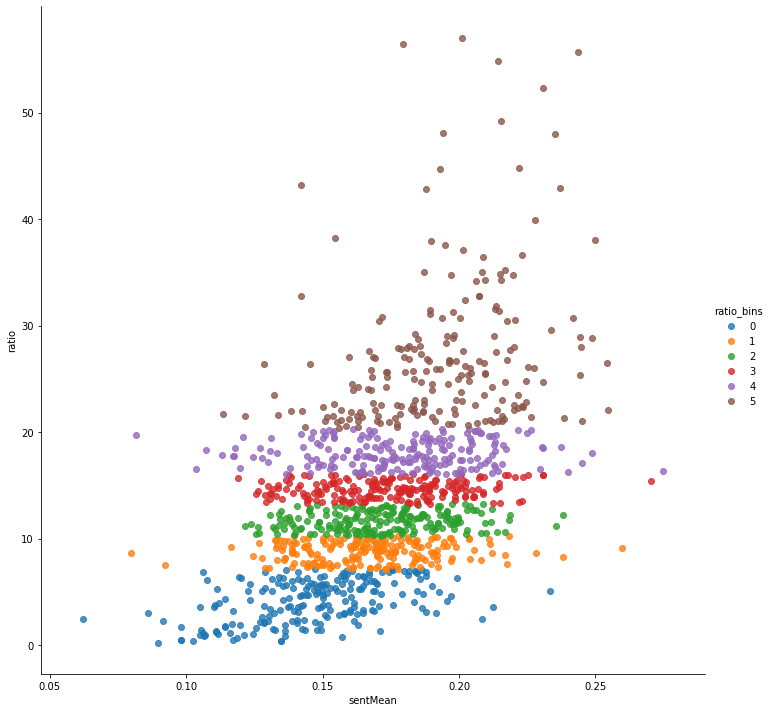

In [14]:
#basic visualisation of ratio between sentiment and ratio
_p = sns.lmplot("sentMean", "ratio", data=vids, fit_reg=False, hue='ratio_bins', height=10)

## to do: visualisation and exploration of our data